In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/breast-cancer-detection/valid/0/2030_992775426_png.rf.df85416a26dd4cb665bb104d6a34d303.jpg
/kaggle/input/breast-cancer-detection/valid/0/2564_1570678080_png.rf.135a908f06be029039778a6df2ab5149.jpg
/kaggle/input/breast-cancer-detection/valid/0/2704_781524556_png.rf.c3007300f84e02ef651821761af1c8a9.jpg
/kaggle/input/breast-cancer-detection/valid/0/294_2044098614_png.rf.1f17493146bfa674226f43a711f6c141.jpg
/kaggle/input/breast-cancer-detection/valid/0/866_1033311478_png.rf.ff97b307c7b296343424c8e5aa172c27.jpg
/kaggle/input/breast-cancer-detection/valid/0/370_1943620586_png.rf.6b2845edfbb223f65f126beabd7aee6a.jpg
/kaggle/input/breast-cancer-detection/valid/0/2546_730952035_png.rf.0aa3bdf9935f0ebed78558c5259bc6bb.jpg
/kaggle/input/breast-cancer-detection/valid/0/2282_2092132689_png.rf.8b110ae2768e8650d7b30dce6ed00e36.jpg
/kaggle/input/breast-cancer-detection/valid/0/561_1308043124_png.rf.e7f17d151c0e2df684b5569befe144f1.jpg
/kaggle/input/breast-cancer-detection/valid/0/2112_19

# **Import**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split

from sklearn.model_selection import train_test_split

# **1. Data Import**

In [3]:
base_dir = '/kaggle/input/breast-cancer-detection'

## **Data Transform**

In [4]:
transform = transforms.Compose([
    transforms.Resize((128, 128)), #Resize images 128 x 128
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.5)
])

In [5]:
#Load the Dataset using ImageFolder

dataset = datasets.ImageFolder(base_dir, transform = transform)

## **Split Data**

In [6]:
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [7]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
len(dataset)

3383

# **2. Data Visualization**

In [9]:
def show_images(loader):
    images, labels = next(iter(loader))
    images = images.numpy()  # Convert to numpy array
    
    plt.figure(figsize=(8, 8))
    
    for i in range(9):  # Show 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i][0], cmap='gray')
        plt.axis("off")
    plt.show()

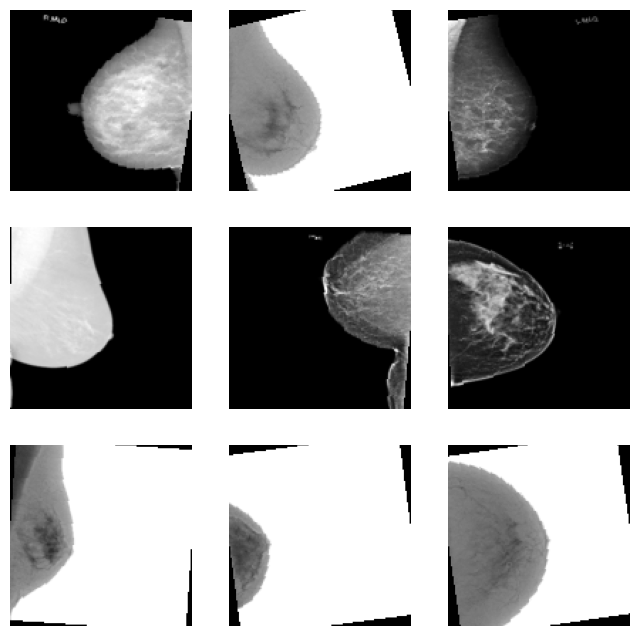

In [10]:
show_images(train_loader)

# **3. Modeling**

## **CNN**

In [11]:
class Net(nn.Module):
    def __init__(self) :
        super(Net,self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2) 
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.fc1 = nn.Linear(64 * 32 * 32, 256)
        self.fc2 = nn.Linear(256, 3)
        
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## **Train**

In [14]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        val_loss, val_acc = evaluate_model(model, val_loader, criterion)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}, Val Loss: {val_loss}, Val Acc: {val_acc}")

## **Evaluation**

In [15]:
def evaluate_model(model, data_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return running_loss/len(data_loader), accuracy

In [16]:
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20)

Epoch 1/20, Loss: 0.879535856279167, Val Loss: 0.8380782157182693, Val Acc: 69.42800788954635
Epoch 2/20, Loss: 0.8162215287620956, Val Loss: 0.8194879405200481, Val Acc: 69.42800788954635
Epoch 3/20, Loss: 0.8168973431393907, Val Loss: 0.8266418501734734, Val Acc: 69.42800788954635
Epoch 4/20, Loss: 0.8073858103236636, Val Loss: 0.8424092493951321, Val Acc: 69.42800788954635
Epoch 5/20, Loss: 0.8119048415809065, Val Loss: 0.8375846073031425, Val Acc: 69.42800788954635
Epoch 6/20, Loss: 0.8141455030119097, Val Loss: 0.8142283298075199, Val Acc: 69.42800788954635
Epoch 7/20, Loss: 0.8024650610782005, Val Loss: 0.8144880719482899, Val Acc: 69.42800788954635
Epoch 8/20, Loss: 0.8007618631865527, Val Loss: 0.8275218978524208, Val Acc: 69.42800788954635
Epoch 9/20, Loss: 0.7981581438232113, Val Loss: 0.8234510086476803, Val Acc: 69.42800788954635
Epoch 10/20, Loss: 0.7992799290128656, Val Loss: 0.8279138840734959, Val Acc: 69.42800788954635
Epoch 11/20, Loss: 0.793846346236564, Val Loss: 0.

In [17]:
test_loss, test_acc = evaluate_model(model, test_loader, criterion)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}%")

Test Loss: 0.8756887577474117, Test Accuracy: 69.48818897637796%
